In [25]:
import sys
sys.path.append("../") # go to parent dir

In [26]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [28]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [128]:
from utils import *

In [23]:
tst = np.array([1.1,2.0], dtype=np.float64)
torch.from_numpy(tst)
# torch.FloatTensor(tst)


 1.1000
 2.0000
[torch.DoubleTensor of size 2]

In [45]:
torch.Tensor(np.array([1.0]))


 1
[torch.FloatTensor of size 1]

In [92]:
tst.astype(np.float32)

array([1., 2.], dtype=float32)

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.backends.cudnn.enabled

True

In [30]:
PATH = '/home/paperspace/kaggle/humpback/'

Let's first try to just produce a convolutional learner, by creating a new folder for the dataset with the proper train/test stuff.

In [47]:
# from planet import f2

metrics=[accuracy, map5]
f_model = resnet50

In [48]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=0.195)

In [49]:
# n, (n - len(val_idxs)) % 64, len(val_idxs) % 64

In [50]:
len(val_idxs) / n

0.19498442490438075

In [168]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, bs=64, \
                                        tfms=tfms, val_idxs=val_idxs, test_name='test')

In [169]:
sz = 512 # The size the images will be transformed, to make it run faster

data = get_data(sz)

In [170]:
# data = data.resize(int(sz*1.3), 'tmp')

In [171]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics, pretrained=True)

 72%|███████▏  | 1831/2552 [06:13<02:27,  4.90it/s, loss=22.7]

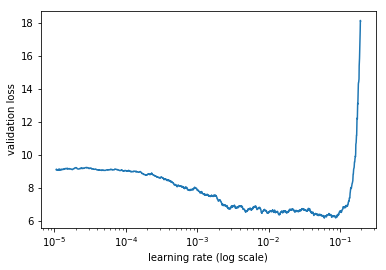

In [164]:
### Run this with batch size of 8 or 16
lrf=learn.lr_find()
learn.sched.plot()

For ResNet34 and sz = 512, the best lr was 2e-3.
For ResNet50 and sz = 224, the best lr was 2e-3.
For ResNet50 and sz = 512, the best lr was 1e-3.

In [165]:
# learn.get_layer_groups()

In [166]:
lr = 1e-3

In [172]:
learn.fit(lr, 3, cycle_len=1)#, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   map5            
    0      7.685524   7.550469   0.23822    0.241483  
    1      7.046195   6.765223   0.304752   0.307176        
    2      6.474214   6.208227   0.352882   0.355527        


[array([6.20823]), 0.35288169878196907, 0.35552746962729553]

In [173]:
lrs = np.array([lr/100,lr/10,lr])

In [174]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=1)

  0%|          | 0/319 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

Best map5 for the train set was 0.39. Splitting the train/test set will automatically give me funny validation though, since there are things in the validation set that I never train on.

In [146]:
preds = learn.predict(is_test=True)
# preds, _ = learn.TTA(is_test=True)

In [116]:
mkdir -p subs

In [159]:
name = f'res50-no-TTA-corrected-{sz}'

In [148]:
top_5 = top_5_preds(preds)

In [149]:
preds.shape

(7960, 5005)

In [133]:
top_5.dtype

dtype('int64')

In [140]:
preds_mean = preds.mean(axis=0)

In [141]:
# for i in range(top_5.shape[0]):

In [160]:
create_submission(preds, learn.data, name)

In [161]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,68f340d0c.jpg,new_whale w_3de579a w_51fc1fc w_d066f46 w_9769f0b
1,e630231e9.jpg,new_whale w_9c506f6 w_5e8e218 w_564a34b w_60ce6fc
2,ede743c5f.jpg,new_whale w_5e8e218 w_9c506f6 w_3fe5d56 w_3aa8e97
3,23877c73f.jpg,new_whale w_57bf435 w_e2561dd w_31b5dd8 w_da577dd
4,ad3afe7cb.jpg,new_whale w_d44dfdc w_3bb142c w_b3e445e w_30f2f0f


In [162]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|█████████████████████████████████████████| 147k/147k [00:01<00:00, 126kB/s]
Successfully submitted to Humpback Whale Identification

In [72]:
val = learn.predict()

In [73]:
# map5(val, data.val_y)

In [75]:
valexp = np.exp(val)

In [96]:
srtd = np.argsort(valexp, axis=1)[:,::-1]

In [98]:
valexp[1,srtd[0,:]]

array([0.17679, 0.00023, 0.00012, ..., 0.00012, 0.00017, 0.00018], dtype=float32)

In [101]:
top5indx = srtd[:,:5]

In [111]:
len(top5indx)

4945

In [109]:
data.val_y.T

array([4111, 2751,  710, ...,    0,    0,    0])

In [114]:
mapk(data.val_y.reshape(-1,1), top5indx, 5)

0.01458375463431075

In [64]:
data.val_y

array([4111, 2751,  710, ...,    0,    0,    0])

In [52]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f1                        
    0      0.614549   0.689203   0.806935  
    1      0.622797   0.775748   0.781169                  
    2      0.471155   0.66476    0.819312                  
    3      0.7305     0.821023   0.806877                  
    4      0.534834   0.627191   0.862806                  
    5      0.404633   0.622959   0.855237                  
    6      0.244604   0.620723   0.858246                  


[array([0.62072]), 0.8582458376870382]

In [53]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f1                        
    0      0.316106   0.677333   0.841587  
    1      0.379357   0.727948   0.841817                  
    2      0.322998   0.644181   0.846078                  
    3      0.310452   0.740814   0.815987                  
    4      0.327104   0.720828   0.840056                  
    5      0.225332   0.626399   0.846601                  
    6      0.24042    0.644061   0.850857                  


[array([0.64406]), 0.8508574768034846]

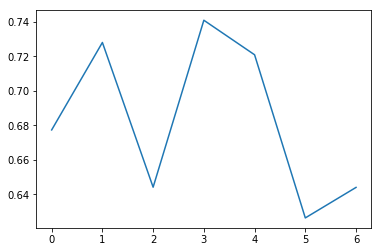

In [54]:
plt.plot(learn.sched.val_losses)